In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from data.map_dataset import MapDataset
from data.load_neural_activity import load_dataset, pick_worm

### **Experiment 0:** Baselines.

In [3]:
# @title Choose one worm from one of the datasets.
# @markdown

# choose your dataset
dataset_name = "Nichols2017"
all_worms_dataset = load_dataset(dataset_name)
print("Chosen dataset:", dataset_name)
print()

# get data for one worm
worm = np.random.choice(list(all_worms_dataset.keys()))
single_worm_dataset = pick_worm(all_worms_dataset, worm)
print("Picked:", worm)
print()

# get the calcium data for this worm
calcium_data = single_worm_dataset["data"]
print("worm calcium-signal dataset:", calcium_data.shape)
print()

# get the neuron ids and length of the recording
neuron_ids = single_worm_dataset["neuron_ids"]
max_time = single_worm_dataset["max_time"]
num_neurons = single_worm_dataset["num_neurons"]

Chosen dataset: Nichols2017

Picked: worm26

worm calcium-signal dataset: torch.Size([4943, 99, 1])



#### Effect of $\tau$ on MSE.
Without training, what is the residual $\Delta Y(\tau)$ between the _value_ $Y(t)$ and the _value_ at $Y(t+\tau)$ as a function of $\tau$?

$\Delta Y(\tau) = Y(t+\tau) - Y(t)$

$\Delta Y(\tau) \propto \operatorname{MSE} \: \left(Y(t+\tau), Y(t)\right)$

In [4]:
# @title Create dataloaders.
# @markdown

metric = torch.nn.MSELoss()
max_tau = 200

# create a collection of datasets, one for each tau
datasets = [
    MapDataset(calcium_data, size=100, seq_len=1, tau=i) for i in range(1, max_tau + 1)
]  # all datasets contains length 1 sequences

# create a sequence of dataloaders, one for each dataset
dataloaders = [torch.utils.data.DataLoader(dataset) for dataset in datasets]

In [5]:
# @title Create dataloaders.
# @markdown

metric = torch.nn.MSELoss()
max_tau = 200

# create a collection of datasets, one for each tau
datasets = [
    MapDataset(calcium_data, size=100, seq_len=1, tau=i) for i in range(1, max_tau + 1)
]  # all datasets contains length 1 sequences

# create a sequence of dataloaders, one for each dataset
dataloaders = [torch.utils.data.DataLoader(dataset) for dataset in datasets]

In [6]:
# @title Calculate the baseline loss for each $\tau$.
# @markdown

baselines = [[] for i in range(1, max_tau + 1)]
for dataloader in dataloaders:
    for data in dataloader:
        X, Y, meta = data
        tau = meta["tau"].item()
        baselines[tau - 1].append(metric(X, Y).item())

baselines = np.array(baselines).T
print(baselines.shape)

(100, 200)


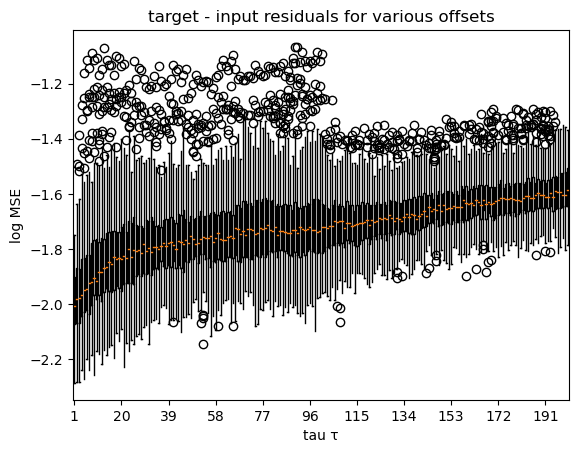

In [7]:
# @title Plot baseline as function of $\tau$.
# @markdown

plt.figure()
plt.boxplot(np.log10(baselines))
plt.gca().set_xticks(np.arange(1, max_tau + 1, 19))
plt.gca().set_xticklabels(np.arange(1, max_tau + 1, 19))
plt.xlabel("tau τ")
plt.ylabel("log MSE")
plt.title("target - input residuals for various offsets")
plt.show()

#### Effect of sequence length $L$ on MSE.
Without training, what is the average residual $\Delta Y(L)$ between the length $L$ _sequence_ starting at $\mathbf{Y}(t)$ and the length $L$ _sequence_ starting at $\mathbf{Y}(t+1)$ as a function of $L$?

$\Delta Y(L) \propto \operatorname{MSE} \: \left( \mathbf{Y}(t+1), \mathbf{Y}(t) \right)$

In [8]:
# @title Create dataloaders.
# @markdown

metric = torch.nn.MSELoss()
max_len = 100

# create a collection of datasets, one for each tau
datasets = [
    MapDataset(calcium_data, size=100, seq_len=i, tau=1) for i in range(1, max_len + 1)
]  # all datasets contains sequences of fixed length

# create a sequence of dataloaders, one for each dataset
dataloaders = [torch.utils.data.DataLoader(dataset) for dataset in datasets]

In [9]:
# @title Calculate the baseline loss for each $L$.
# @markdown

baselines = [[] for i in range(1, max_len + 1)]
for dataloader in dataloaders:
    for data in dataloader:
        X, Y, meta = data
        L = meta["seq_len"].item()
        baselines[L - 1].append(metric(X, Y).item())

baselines = np.array(baselines).T
print(baselines.shape)

(100, 100)


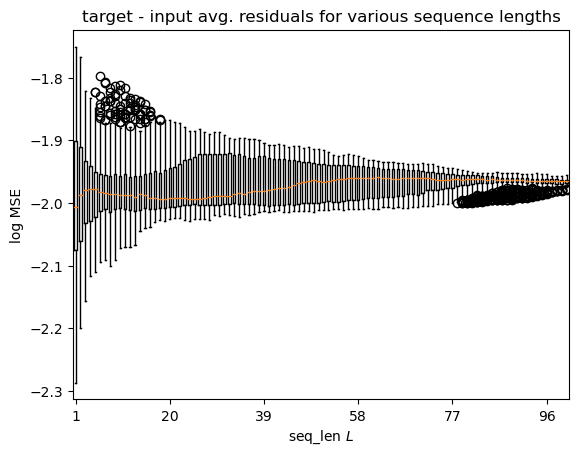

In [10]:
# @title Plot baseline as function of $L$.
# @markdown

plt.figure()
plt.boxplot(np.log10(baselines))
plt.gca().set_xticks(np.arange(1, max_len + 1, 19))
plt.gca().set_xticklabels(np.arange(1, max_len + 1, 19))
plt.xlabel("seq_len $L$")
plt.ylabel("log MSE")
plt.title("target - input avg. residuals for various sequence lengths")
plt.show()